# Emotion Recognition Model Validation

The main objective of this notebook is to validate the trained model for emotion recognition

In [1]:
# Add project path to the PYTHONPATH

import os
import sys
from pathlib import Path

sys.path.append(Path(os.path.join(os.path.abspath(''), '../')).resolve().as_posix())

In [2]:
import pickle

## Load Tokenizer

Load `.pickle` file with the tokenizer

In [3]:
tokenizer_path = Path('/home/rmohashi/hd/emotion/tokenizer.pickle').resolve()
with tokenizer_path.open('rb') as file:
    tokenizer = pickle.load(file)

## Load Model

Load the trained emotion recognition model

In [4]:
from emotion_recognition.models.cnn_model import cnn_model as ml_model

/home/rmohashi/miniconda3/envs/emodata/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/rmohashi/miniconda3/envs/emodata/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/rmohashi/miniconda3/envs/emodata/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/rmohashi/miniconda3/envs/emo

In [5]:
model_weights_path = Path('/home/rmohashi/hd/tweet-emotion-recognition/models/emotion_recognition/checkpoints/cnn_100_30/cnn_100_30_02-0.5095.h5').resolve()
input_dim = min(tokenizer.num_words, len(tokenizer.word_index) + 1)
model = ml_model(30, input_dim, 4, None, embedding_dim=100)
model.load_weights(model_weights_path.as_posix())

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


## Load test dataset

Load the dataset that will be used to test the model

In [6]:
import pandas as pd

In [7]:
test_data_path = Path('../datasets/semeval/testset.csv').resolve()
test_data = pd.read_csv(test_data_path)

In [8]:
test_data.head()

,id,text,label
0,2017-En-31535,Whatever you decide to do make sure it makes y...,joy
1,2017-En-31436,Accept the challenges so that you can literall...,joy
2,2017-En-22190,No but that's so cute. Atsu was probably shy a...,joy
3,2017-En-31337,Tiller and breezy should do a collab album. Ra...,joy
4,2017-En-10618,"The bitter the battle, the sweeter the victory...",joy


## Load Encoder

Load `.pickle` file with the encoder

In [9]:
encoder_path = Path('../models/emotion_recognition/encoder.pickle').resolve()
with encoder_path.open('rb') as file:
    encoder = pickle.load(file)

## Preprocess data

Preprocess the data that will be used

In [10]:
from nlp.utils import preprocess
from tensorflow.keras.preprocessing.sequence import pad_sequences

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/rmohashi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [11]:
test_data['cleaned'] = preprocess(test_data.text, stemming=True)
sequences = [text.split() for text in test_data.cleaned]
list_tokenized = tokenizer.texts_to_sequences(sequences)
x_test = pad_sequences(list_tokenized, maxlen=30)
y_test = encoder.transform(test_data.label)

Time to clean up: 2.31 sec


## Results

Predict the labels and generate a confusion matrix

In [12]:
from sklearn.metrics import classification_report

In [13]:
y_pred = model.predict(x_test)

In [14]:
y_pred = y_pred.argmax(axis=1)
y_test = y_test.argmax(axis=1)

In [15]:
print(classification_report(y_test, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.3790    0.2896    0.3283      1892
           1     0.1571    0.3175    0.2102       630
           2     0.5995    0.4525    0.5157      3397
           3     0.2826    0.4523    0.3479      1059

    accuracy                         0.3961      6978
   macro avg     0.3545    0.3780    0.3505      6978
weighted avg     0.4517    0.3961    0.4118      6978



In [16]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

In [17]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return fig, ax

Normalized confusion matrix
[[0.28964059 0.18763214 0.29809725 0.22463002]
 [0.17142857 0.31746032 0.32698413 0.18412698]
 [0.17809832 0.17073889 0.45245805 0.19870474]
 [0.17469311 0.13031161 0.24268178 0.4523135 ]]


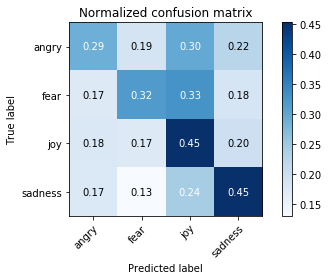

In [18]:
fig, ax = plot_confusion_matrix(y_test, y_pred, encoder.classes_, normalize=True)